In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np                                                    # libraries for data
import re
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
import plotly.express as px
import emoji
import string
import nltk 
from PIL import Image
from collections import Counter                                                #libraries for nltk
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import CountVectorizer                                  # libraries for preparing model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier              # libraries for model_selection
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC , LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
import pickle



In [2]:
df = pd.read_csv(r"C:\Users\Lenovo\Downloads\cyberbullying_tweets.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [4]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
df.tail()

,tweet_text,cyberbullying_type
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity


In [6]:
#checking missing values:

In [7]:
df.isnull().sum()     #no missing values

tweet_text            0
cyberbullying_type    0
dtype: int64

In [8]:
# no of categories :

In [9]:
df["cyberbullying_type"].value_counts()    #Data almost evenly distributed. We dont have class imbalance type of thing.

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

# Data Preprocessing :

In [10]:
#renaming columns name:

In [11]:
df = df.rename(columns={"tweet_text" : "text", "cyberbullying_type" : "sentiment"})

In [12]:
df.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [13]:
# Label Encoding:

In [14]:
df["sentiment_encoded"] = df["sentiment"].replace({ "religion" : 1, "age" : 2, "gender" : 3, "ethnicity" :4,
                                               "not_cyberbullying" : 5,  "other_cyberbullying" :6})

In [15]:
df.tail()

,text,sentiment,sentiment_encoded
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,4
47688,Turner did not withhold his disappointment. Tu...,ethnicity,4
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,4
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,4
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity,4


In [16]:
# nltk.donload("stopwords"):

In [17]:
nltk.download("punkt")  # punkt package to avoid errors

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
nltk.download("wordnet")  #to find the meanings of words, synonyms, antonyms, and more.

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
#stopword removes unnecessary words to reduce complexity in finding the frequency(Tfidf, count_vectorizer).

In [20]:
stop_words = set(stopwords.words('english'))

In [21]:
# Preprocessing of text

In [22]:
# function to remove emojis:

def strip_emoji (text):
    return emoji.replace_emoji(text,replace= "")

In [23]:
#function to convert text to Lowercase, remove (unwanted characrters, urls, non-utf stuff, numbers, stopwords)

def strip_all_entities (text):

    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) 
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub('[0-9]+','',text)

    stopchars = string.punctuation 
    table=str.maketrans('','',stopchars)
    text = text.translate(table)
    
    text=[word for word in text.split() if word not in stop_words] 
    text=' '.join(text)
    
    return text

In [24]:
#function to remove contractions

In [25]:
def decontract (text):

    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    return text

In [26]:
# function to clean hashtags :

In [27]:
def clean_hashtags (tweet):

    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
                                                         
    return new_tweet2

In [28]:
#function to filter special charaters:

def filter_chars(a): 
    sent = []
    for word in a.split(" "): 
        if ("$" in word) | ("&" in word): 
            sent.append('')
        else: 
            sent.append(word)
    return ' '.join(sent)  

In [29]:
# removing sequesces, and applying stemming

def remove_mult_spaces(text):
       return re.sub("\s\s+" , " ", text)


def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])


def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

In [30]:
# using all functions

def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [31]:
df['text_clean'] = df["text"].apply(preprocess)

In [32]:
# another way :
# texts_new = []
# for t in df.text:
#     texts_new.append(preprocess(t))

In [33]:
df.head()

,text,sentiment,sentiment_encoded,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,5,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,5,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,5,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,5,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,5,isi account pretend kurdish account like islam...


In [34]:
df["text_clean"].duplicated().sum()

3040

In [35]:
df.drop_duplicates("text_clean", inplace=True)

In [36]:
#tokenization

In [37]:
df["tweet_list"] = df["text_clean"].apply(word_tokenize)
df.head()

,text,sentiment,sentiment_encoded,text_clean,tweet_list
0,"In other words #katandandre, your food was cra...",not_cyberbullying,5,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,5,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,5,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,5,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,5,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like..."


# EDA

In [38]:
text_len = []
for text in df.tweet_list:
    tweet_len = len(text)
    text_len.append(tweet_len)
    
df["text_len"] = text_len

In [39]:
df.tail()

,text,sentiment,sentiment_encoded,text_clean,tweet_list,text_len
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,4,black ppl expect anyth depend anyth yet free p...,"[black, ppl, expect, anyth, depend, anyth, yet...",21
47688,Turner did not withhold his disappointment. Tu...,ethnicity,4,turner withhold disappoint turner call court a...,"[turner, withhold, disappoint, turner, call, c...",29
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,4,swear god dumb nigger bitch got bleach hair re...,"[swear, god, dumb, nigger, bitch, got, bleach,...",13
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,4,yea fuck rt your nigger fuck unfollow fuck dum...,"[yea, fuck, rt, your, nigger, fuck, unfollow, ...",10
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity,4,bro u got ta chill rt dog fuck kp dumb nigger ...,"[bro, u, got, ta, chill, rt, dog, fuck, kp, du...",13


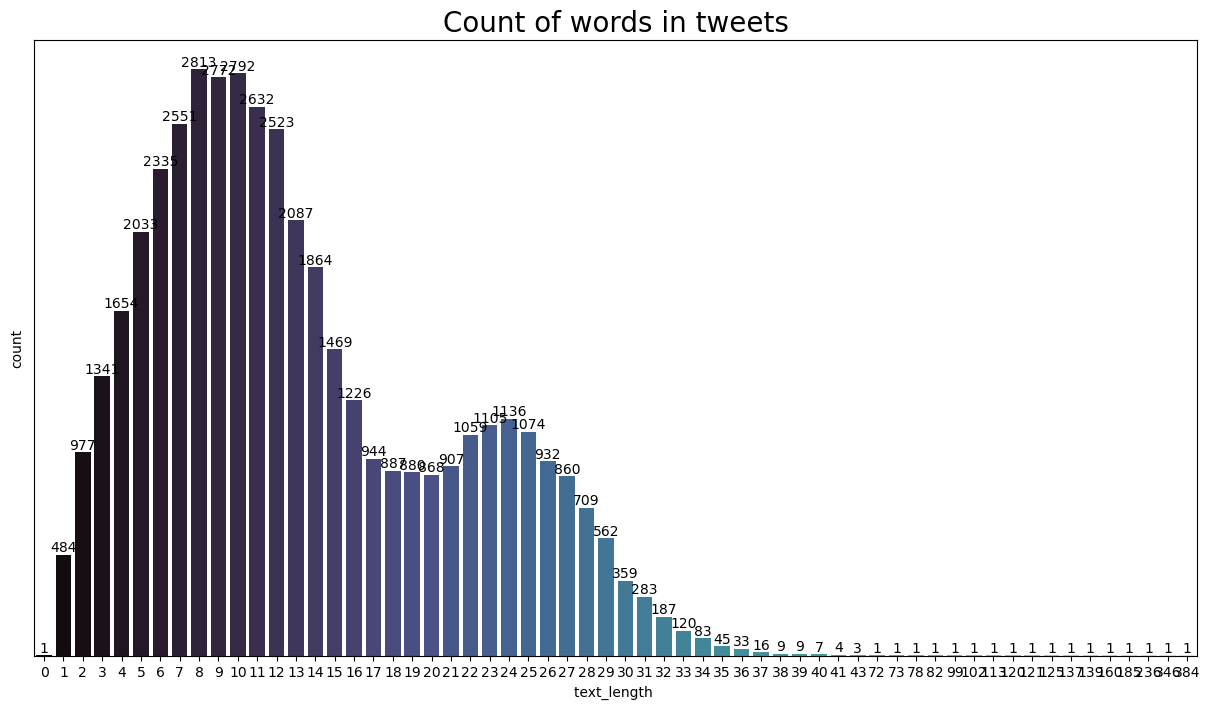

In [40]:
plt.figure(figsize=(15,8))

ax = sns.countplot(x='text_len', data=df, palette="mako") 
plt.title('Count of words in tweets', fontsize=20) 
plt.yticks([]) 
ax.bar_label(ax.containers[0])

plt.ylabel("count") 
plt.xlabel("text_length ")
plt.show()

In [41]:
#removing text without words

In [42]:
df = df[df['text_len']!=0]                    #this is tweet list, not tweets.

In [43]:
df.shape

(44651, 6)

In [44]:
def plot_wordcloud (cyberbullying_type):

    string =" "
    for i in df[df.sentiment == cyberbullying_type].text_clean.values: 
        string = string + " " + i.strip()


    wordcloud = WordCloud(background_color="white", max_words=2000, max_font_size=256,random_state=42).generate(string)

#plot the wordcloud image

    plt.figure(figsize = (7, 7), facecolor = None)
    plt.title(cyberbullying_type)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout (pad = 0)
    plt.show()
    del string

In [45]:
#splitting data based on sentiment for EDA :

In [46]:
not_cyberbullying_type = df[df['sentiment'] == 'not_cyberbullying']
gender_type = df[df['sentiment'] == 'gender']
religion_type = df[df['sentiment'] == 'religion']
other_cyberbullying_type = df[df['sentiment'] == 'other_cyberbullying']
age_type = df[df['sentiment'] == 'age']
ethnicity_type = df[df['sentiment'] == 'ethnicity']


In [47]:
#EDA

In [48]:
gender = Counter ([item for sublist in gender_type["tweet_list"] for item in sublist]) 
top20_gender = pd.DataFrame(gender.most_common (20)) 
top20_gender.columns= ['Top Words', "Count"] 
top20_gender.head(20)

,Top Words,Count
0,joke,5180
1,rape,4070
2,gay,3852
3,call,1401
4,make,1284
5,rt,1221
6,bitch,1146
7,femal,1108
8,peopl,988
9,like,978


Text(0.5, 1.0, 'Top 20 words in Gender Cyberbullying')

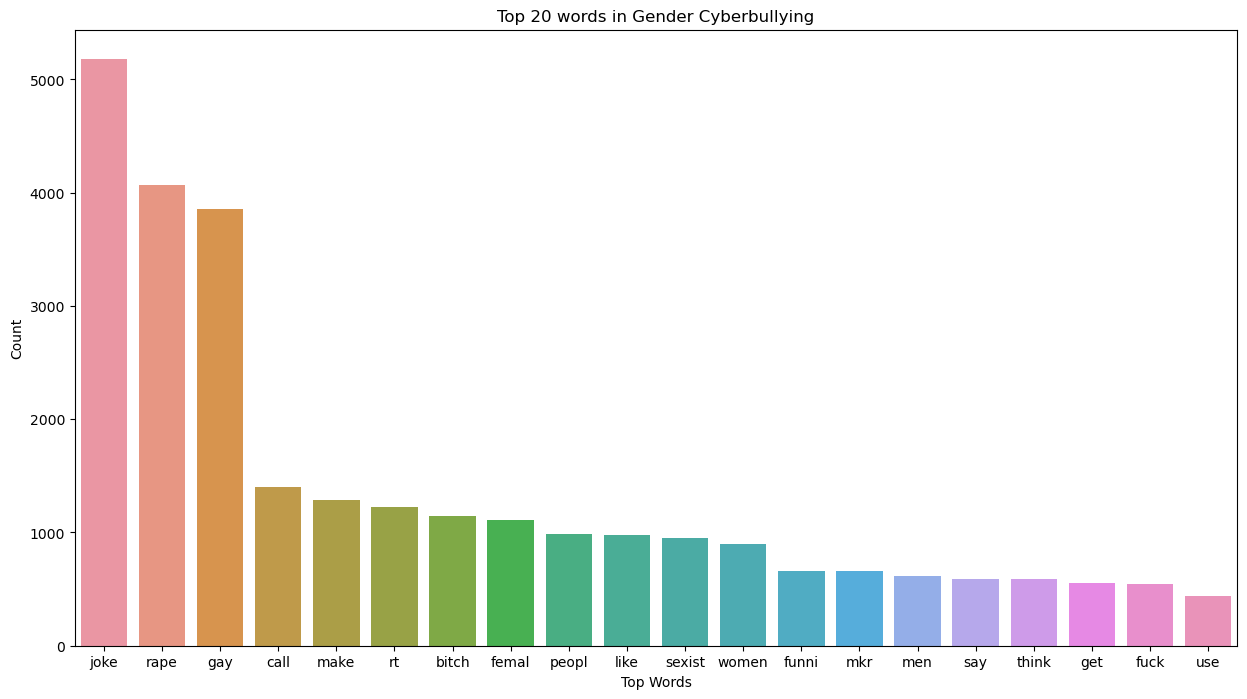

In [49]:
fig= plt.figure(figsize=(15,8))
sns.barplot(data=top20_gender, y="Count", x="Top Words")
plt.title("Top 20 words in Gender Cyberbullying")

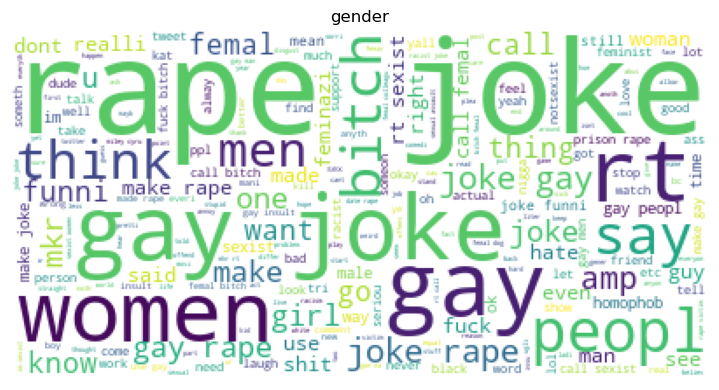

In [50]:
plot_wordcloud('gender')

In [51]:
#religion based cyberbullying

religion= Counter ([item for sublist in religion_type[ 'tweet_list'] for item in sublist])
top20_religion = pd.DataFrame(religion.most_common(20))

top20_religion.columns = ['Top words', 'Count'] 
top20_religion.style.background_gradient(cmap='Greens')

,Top words,Count
0,muslim,4618
1,idiot,3075
2,islam,2440
3,christian,2132
4,u,1449
5,terrorist,1379
6,right,1291
7,like,1276
8,support,1251
9,terror,1182


Text(0.5, 1.0, 'Top 20 words in Religion Cyberbullying')

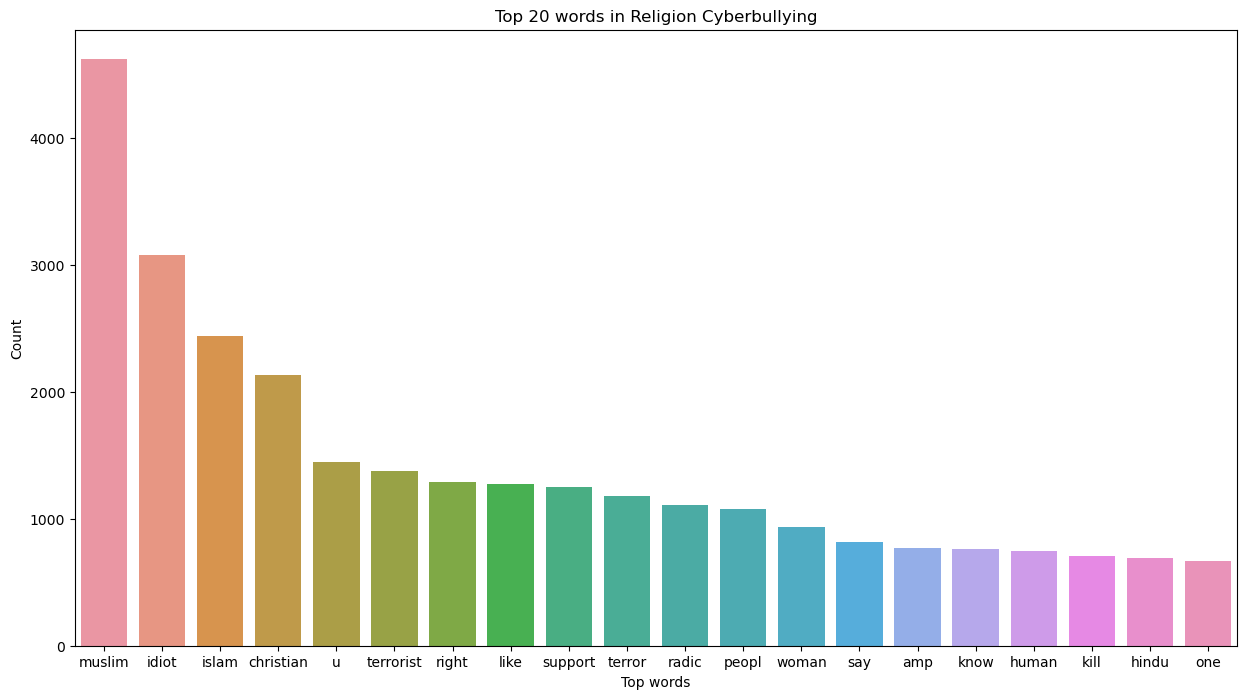

In [52]:
fig= plt.figure(figsize=(15,8))
sns.barplot(data=top20_religion, y="Count",x = 'Top words')
plt.title("Top 20 words in Religion Cyberbullying")

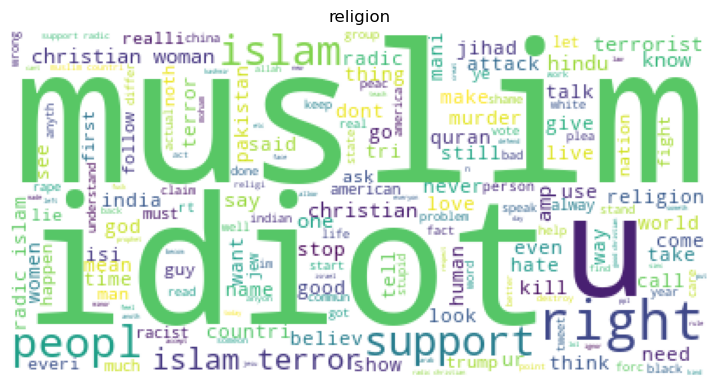

In [53]:
plot_wordcloud('religion')

In [54]:
#age based cyber bullying

In [55]:
age= Counter ([item for sublist in age_type[ 'tweet_list'] for item in sublist])
top20_age = pd.DataFrame(age.most_common(20))

top20_age.columns = ['Top words', 'Count'] 
top20_age.style.background_gradient(cmap='Greens')

,Top words,Count
0,bulli,8903
1,school,8428
2,high,4861
3,girl,4616
4,like,2080
5,get,1052
6,one,1044
7,peopl,934
8,got,842
9,kid,809


Text(0.5, 1.0, 'Top 20 words in age Cyberbullying')

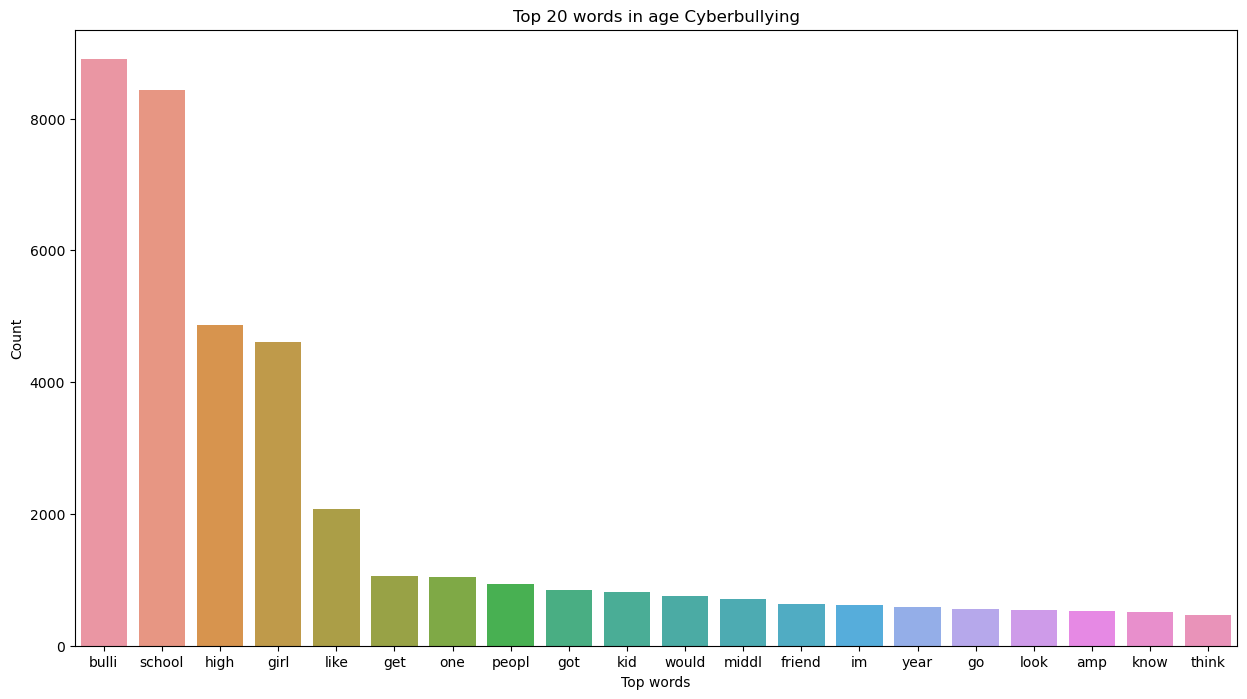

In [56]:
fig= plt.figure(figsize=(15,8))
sns.barplot(data=top20_age, y="Count",x = 'Top words')
plt.title("Top 20 words in age Cyberbullying")

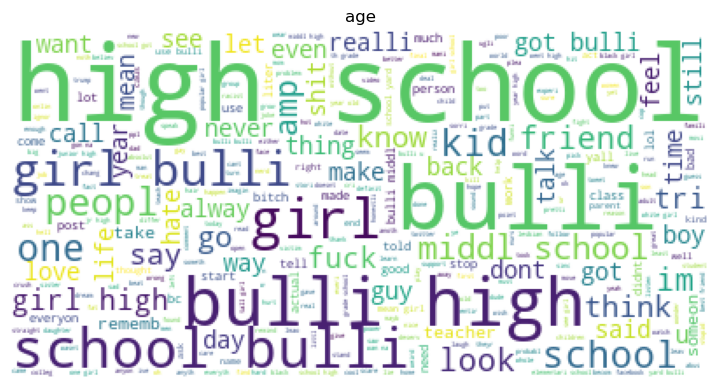

In [57]:
plot_wordcloud('age')

In [58]:
#ethinicity based cyberbullying

In [59]:
ethnicity= Counter ([item for sublist in ethnicity_type[ 'tweet_list'] for item in sublist])
top20_ethnicity = pd.DataFrame(ethnicity.most_common(20))

top20_ethnicity.columns = ['Top words', 'Count'] 
top20_ethnicity.style.background_gradient(cmap='Greens')

,Top words,Count
0,fuck,5892
1,nigger,5458
2,dumb,5003
3,ass,2241
4,black,2134
5,u,1789
6,white,1557
7,call,1381
8,peopl,1182
9,rt,1166


Text(0.5, 1.0, 'Top 20 words in ethinicity Cyberbullying')

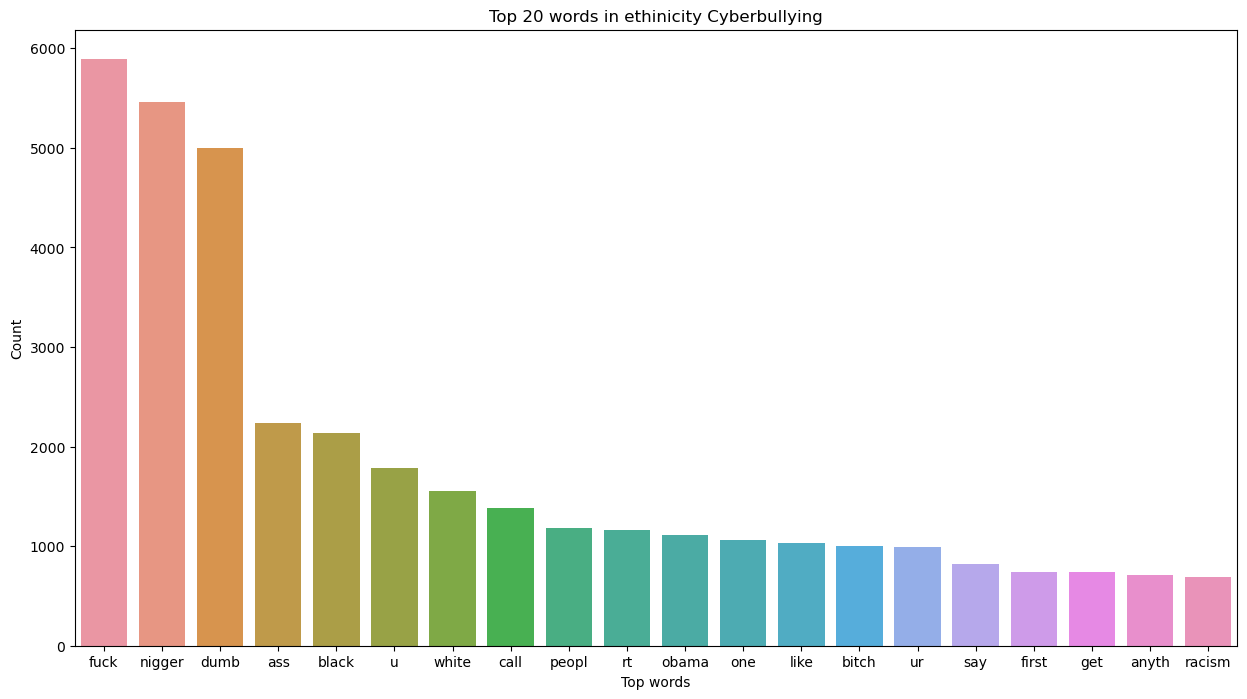

In [60]:
fig= plt.figure(figsize=(15,8))
sns.barplot(data=top20_ethnicity, y="Count", x = 'Top words')
plt.title("Top 20 words in ethinicity Cyberbullying")

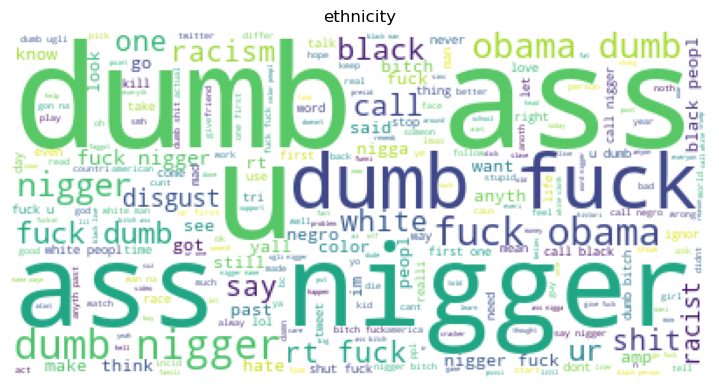

In [61]:
plot_wordcloud('ethnicity')

In [62]:
other_cyberbullying = Counter([item for sublist in other_cyberbullying_type['tweet_list'] for item in sublist])
Top20_other_cyberbullying = pd.DataFrame(other_cyberbullying.most_common(20))
Top20_other_cyberbullying.columns = ['Top Words', 'Count']
Top20_other_cyberbullying.style.background_gradient(cmap="Greens")


,Top Words,Count
0,bulli,881
1,rt,727
2,fuck,509
3,like,424
4,get,393
5,peopl,353
6,go,277
7,idiot,261
8,know,241
9,think,237


Text(0.5, 1.0, 'Top 20 words in other Cyberbullying')

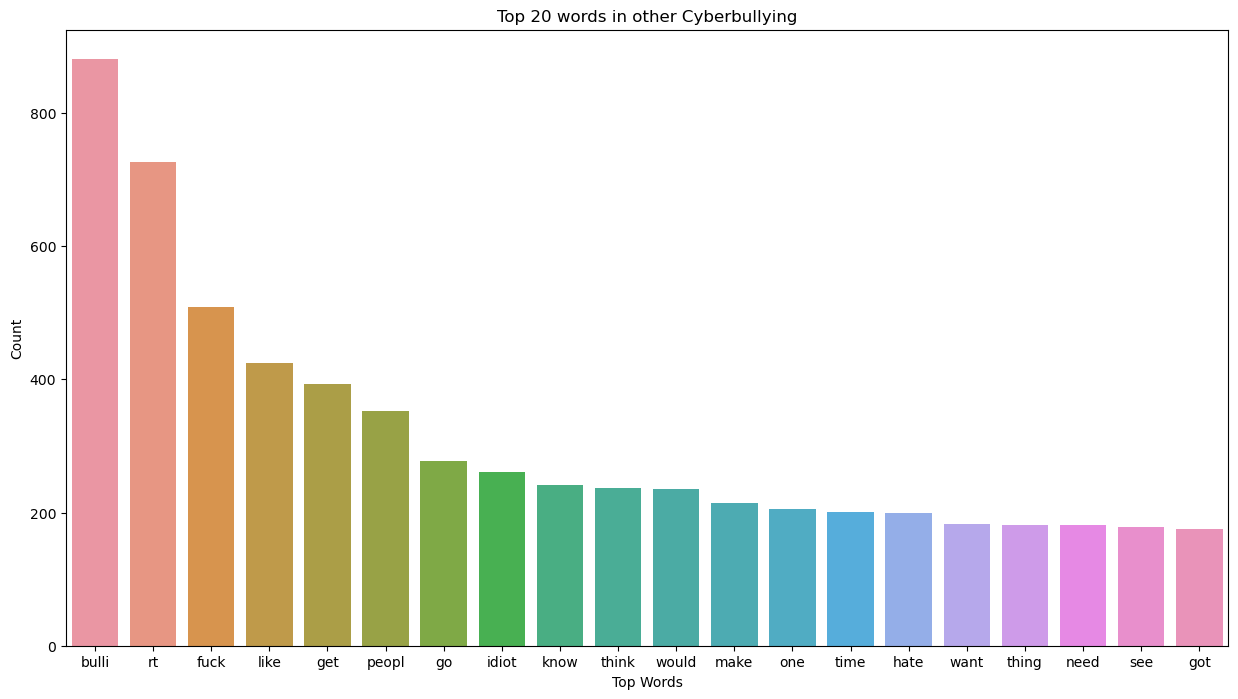

In [63]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=Top20_other_cyberbullying, y="Count", x = 'Top Words')
plt.title("Top 20 words in other Cyberbullying")

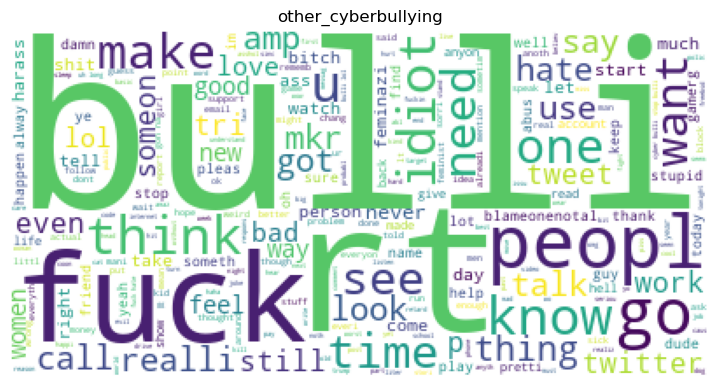

In [64]:
plot_wordcloud('other_cyberbullying')

In [65]:
# tweets with no cyberbullying type :

In [66]:
not_cyberbullying = Counter([item for sublist in not_cyberbullying_type['tweet_list'] for item in sublist])
top20_not_cyberbullying = pd.DataFrame(not_cyberbullying.most_common(20))
top20_not_cyberbullying.columns = ['Top Words', 'Count']
top20_not_cyberbullying.style.background_gradient(cmap="Greens")


,Top Words,Count
0,mkr,1675
1,bulli,1102
2,rt,785
3,like,424
4,get,423
5,go,394
6,school,374
7,kat,286
8,would,286
9,peopl,272


Text(0.5, 1.0, 'Top 20 words in not Cyberbullying')

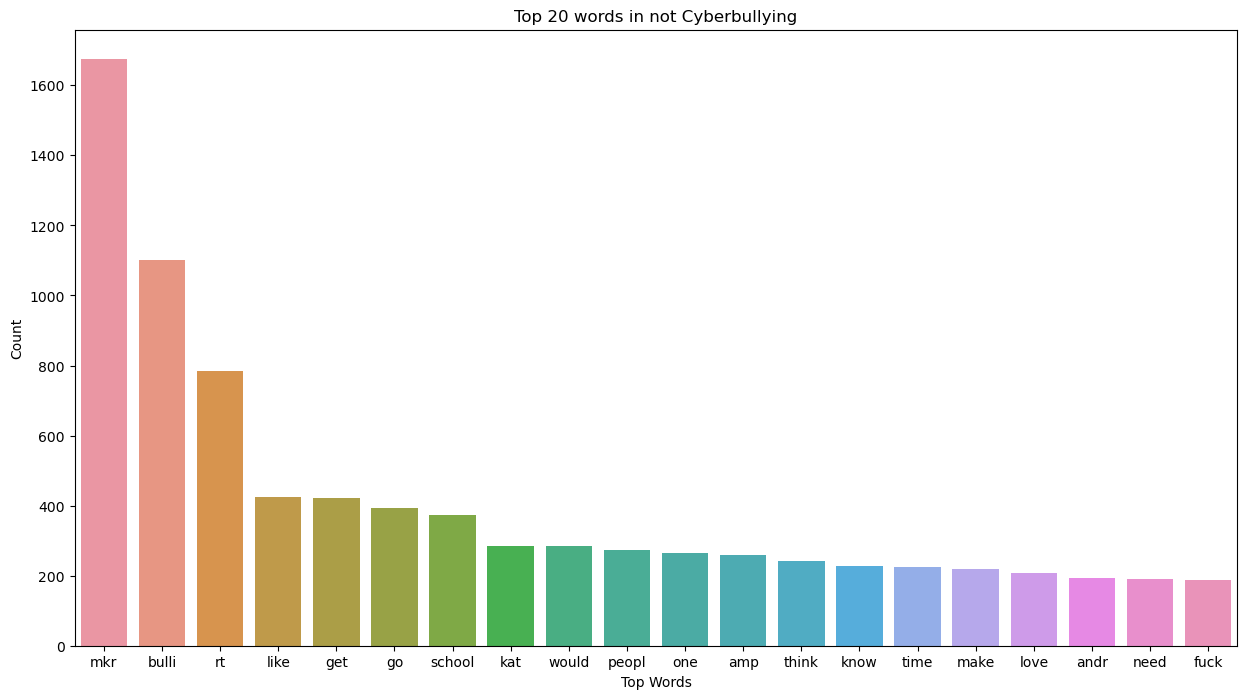

In [67]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_not_cyberbullying, y="Count", x = 'Top Words')
plt.title("Top 20 words in not Cyberbullying")

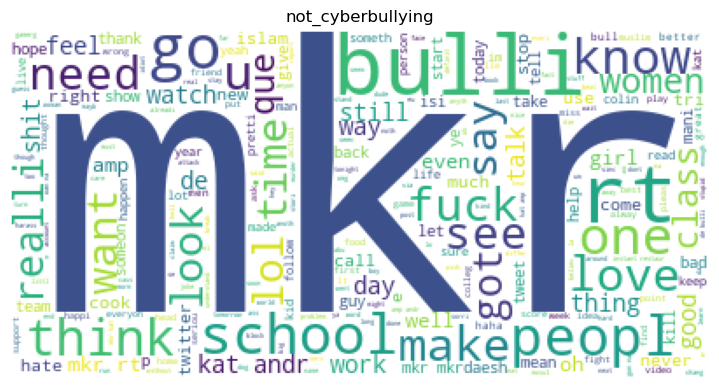

In [68]:
plot_wordcloud("not_cyberbullying")

In [69]:
df.head()

,text,sentiment,sentiment_encoded,text_clean,tweet_list,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,5,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]",5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,5,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya...",11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,5,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]",5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,5,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d...",9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,5,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like...",8


In [70]:
sentiments = ['religion', 'age', 'ethnicity', 'gender', 'other_cyberbullying', 'not_cyberbullying']

# Model Building : Going from less complex model to higher

In [71]:
#splitting data in train and test split:

In [72]:
X,Y = df['text_clean'],df['sentiment_encoded']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify =Y, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(31255,) (31255,) (13396,) (13396,)


In [74]:
#tf - idf vectorization

In [75]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)   #tfidf learn some paramaeter from train data 
X_test_tf = tf_idf.transform(X_test)  #tfidf implement the same parameter in test data
print(X_train_tf.shape)
print(X_test_tf.shape)

(31255, 29192)
(13396, 29192)


In [76]:
#trying different models

In [77]:
#Logistics

log_reg = LogisticRegression()

In [78]:
log_cv_score = cross_val_score(log_reg,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)

In [79]:
mean_log_cv = np.mean(log_cv_score)
mean_log_cv

0.8260294051107474

In [80]:
#support vector

In [81]:
lin_svc = LinearSVC()

In [82]:
lin_svc_cv_score = cross_val_score(lin_svc,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_lin_svc_cv = np.mean(lin_svc_cv_score)
mean_lin_svc_cv

0.8212648821911802

In [83]:
#naive bayes classifier: because we are trying different pattern to choose our machine learning model, going from less
#complexto higher complex


In [84]:
multiNB = MultinomialNB()

In [85]:
multiNB_cv_score = cross_val_score(multiNB,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_multiNB_cv = np.mean(multiNB_cv_score)
mean_multiNB_cv

0.6764214778335604

In [86]:
# At a  time we'll realise that increasing complexity won't increase my performance so it is a sign we need to stop.

In [87]:
# So now we'll use decision tree :

In [88]:
dtree = DecisionTreeClassifier()

In [89]:
dtree_cv_score = cross_val_score(dtree,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_dtree_cv = np.mean(dtree_cv_score)
mean_dtree_cv

0.8102459814688677

In [90]:
#Decision tree giving better result than naive bayes.

In [91]:
#random forest classifier

In [92]:
rand_forest = RandomForestClassifier()

In [93]:
rand_forest_cv_score = cross_val_score(rand_forest,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_rand_forest_cv = np.mean(rand_forest_cv_score)
mean_rand_forest_cv

0.8300536451599319

In [94]:
#ada boost classifier

In [95]:
adab=AdaBoostClassifier()

In [96]:
adab_cv_score = cross_val_score(adab,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_adab_cv = np.mean(adab_cv_score)
mean_adab_cv

0.76426459293758

In [97]:
#By trying different models we can see logistic regression, svm and random forest classifier performed similarly, so among these we will go with svm model as it is more generalised and light

In [98]:
#tuning SVC

In [101]:
from sklearn.model_selection import GridSearchCV


In [102]:
svc1 = LinearSVC()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10],
             'loss':['hinge','squared_hinge'],
             'fit_intercept':[True,False]}
grid_search = GridSearchCV(svc1,param_grid,cv=5,scoring='f1_macro',n_jobs=-1,verbose=0,return_train_score=True)
grid_search.fit(X_train_tf,y_train)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='f1_macro')

In [103]:
grid_search.best_estimator_

LinearSVC(C=1, loss='hinge')

In [104]:
grid_search.best_score_

0.8251533819720226

In [105]:
#evalutaion

lin_svc.fit(X_train_tf,y_train)

y_pred = lin_svc.predict(X_test_tf)


In [111]:
# confusion matrix gives compaarison between actual value and predicted value for each particular class.

In [112]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

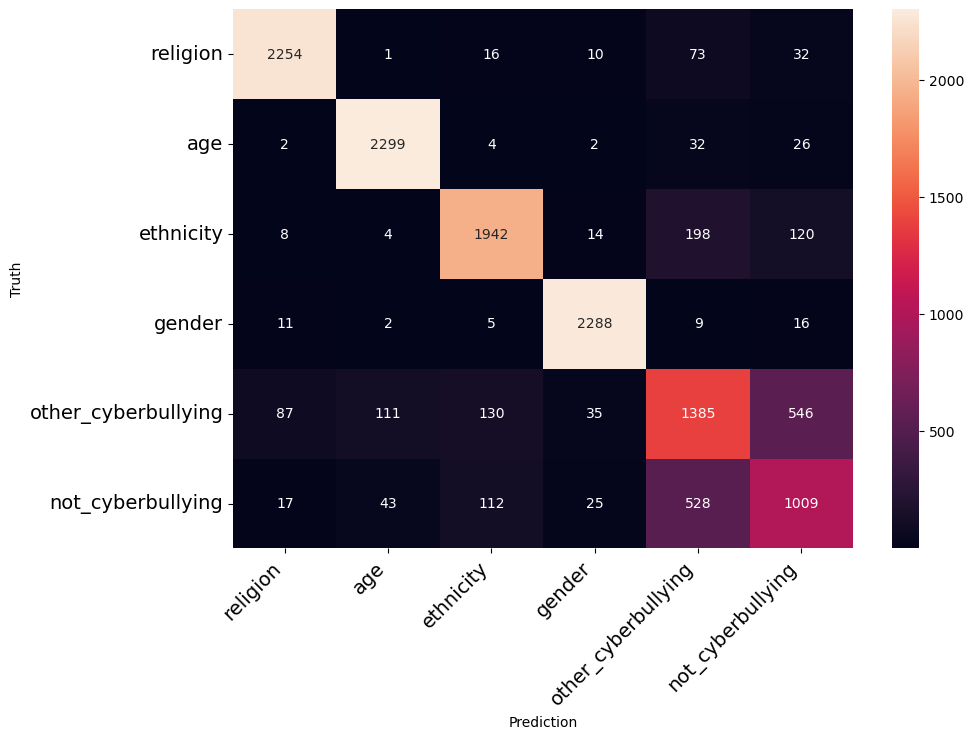

In [113]:
cm = confusion_matrix(y_test,y_pred)
print_confusion_matrix(cm,sentiments)

In [114]:
print('Classification Report:\n',classification_report(y_test, y_pred, target_names=sentiments))

Classification Report:
                      precision    recall  f1-score   support

           religion       0.95      0.94      0.95      2386
                age       0.93      0.97      0.95      2365
          ethnicity       0.88      0.85      0.86      2286
             gender       0.96      0.98      0.97      2331
other_cyberbullying       0.62      0.60      0.61      2294
  not_cyberbullying       0.58      0.58      0.58      1734

           accuracy                           0.83     13396
          macro avg       0.82      0.82      0.82     13396
       weighted avg       0.83      0.83      0.83     13396

